In [1]:
from rawio.IO import *
import ROOT 
import root_numpy

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option("display.max_row", 100)
import numpy as np

import sys
import os, os.path 
import fnmatch
import glob

Welcome to JupyROOT 6.24/06


In [2]:
supersim = os.environ["CDMS_SUPERSIM"]
# Pull in Warren's detector-channel drawing utility from SuperSim
sys.path.append(os.path.join(supersim,"CDMSscripts","validation"))
import detectorLayout

In [3]:
# Function to convert our C-style char[] strings to RDataFrame std::strings
# Why doesn't ROOT do this automatically (or have an option to do so)?
ROOT.gInterpreter.Declare("""
std::string convertToString(const ROOT::VecOps::RVec<Char_t>& vec) {
    std::string s;
    size_t length = vec.size();
    for (size_t i = 0; vec[i]!='\\0'; ++i) {   // Takes care of arrays with extra NUL at end
        s += vec[i];
        }
    return s;
    }
 """)

True

In [4]:
## NOTE: This version is for ROOT 6.24 and earlier; in ROOT 6.26, use rdf.Redefine() 
def cast_columns(rdf):
    """Convert char[] (C-style string) TBranches to strings, with new column names
       Usage: fixed_rdf = cast_columns(ROOT::RDataFrame(.....))
       After calling data = fixed_rdf.AsNumpy(), the original column name can be restored with
       data['Branch'] = data.pop('Branch_cast')
    """
    for column in rdf.GetColumnNames():
        if rdf.GetColumnType(column) == "ROOT::VecOps::RVec<Char_t>":
            rdf = rdf.Define(f"{column}_cast", f"convertToString({column})")
            # NOTE: No way to rename or delete a column before 6.26; do it later via Numpy 
    return rdf

In [5]:
def cast_array(data):
    """Convert RDataFrame array columns to Numpy arrays, can replace in situ
       Usage: numpy['Branch'] = cast_array(numpy['Branch'])
    """
    casted_row = []
    for row in data:
        casted_row.append([i for i in row])
    return np.array(casted_row)

In [6]:
def getSharingData(file):
    """Extract useful hit and energy-sharing information from specified file
       Usage: numpyData = getSharingData('myRootFile.root')
    """
    branches = ['EventNum','TrkStep','PName','X3','Y3','Z3','Edep','PhononE','ChargeQ']
    rdf = cast_columns(ROOT.RDataFrame("G4SimDir/mczip0", file, branches))
    data = rdf.AsNumpy(branches+['PName_cast'])
    data['PName'] = data.pop('PName_cast')
    data['PhononE'] = cast_array(data['PhononE'])
    data['ChargeQ'] = cast_array(data['ChargeQ'])
    return data

In [9]:
iZIP5File = 'data/FastDMC/FastDMC-356keV_00230930_0000.root'
HV100mmFile = 'data/FastDMC/HV100mmSi-Sharing-10keV_00230928_000000.root'

In [10]:
iZIP5data = getSharingData(iZIP5File)
HV100mmData = getSharingData(HV100mmFile)

In [11]:
# Will want to get channel names from G4SettingsInfo/Geometry.ChanName list
iZIP5qChans = ['Qo1','Qi1','Qo2','Qi2']
iZIP5phChans = ['PAS1','PBS1','PCS1','PDS1','PAS2','PBS2','PCS2','PDS2']
HVqChans = []
HVphChans = ['PAS1','PBS1','PCS1','PDS1','PES1','PFS1','PAS2','PBS2','PCS2','PDS2','PES2','PFS2']

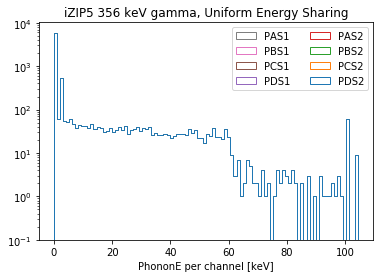

In [12]:
fig,axes = plt.subplots()
axes.hist(iZIP5data['PhononE']/1e3,bins=100,histtype='step',fill=False,log=True)
axes.legend(iZIP5phChans,loc="upper right",ncol=2)
axes.set_xlabel("PhononE per channel [keV]")
axes.set_title("iZIP5 356 keV gamma, Uniform Energy Sharing")
fig.savefig("iZIP5_sharing-phChans.png")

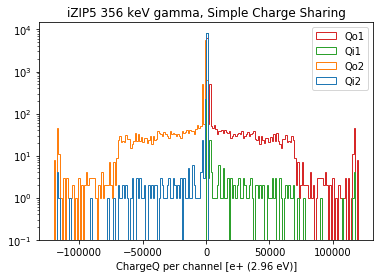

In [13]:
fig,axes = plt.subplots()
axes.hist(iZIP5data['ChargeQ'],bins=200,histtype='step',fill=False,log=True)
axes.legend(iZIP5qChans,loc="upper right")
axes.set_xlabel("ChargeQ per channel [e+ (2.96 eV)]")
axes.set_title("iZIP5 356 keV gamma, Simple Charge Sharing")
fig.savefig("iZIP5_sharing-qChans.png")

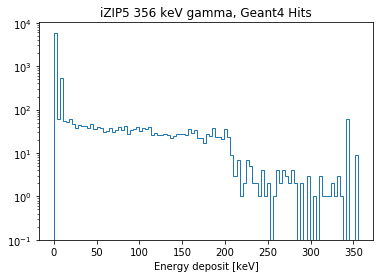

In [14]:
fig,axes = plt.subplots()
axes.hist(iZIP5data['Edep']/1e3,bins=100,histtype='step',fill=False,log=True)
axes.set_xlabel("Energy deposit [keV]")
axes.set_title("iZIP5 356 keV gamma, Geant4 Hits")
fig.savefig("iZIP5_sharing-Edep.png")

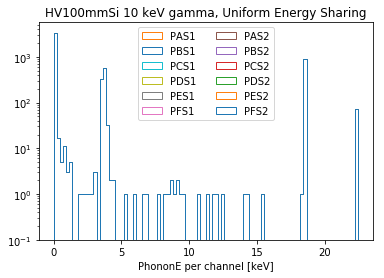

In [19]:
fig,axes = plt.subplots()
axes.hist(HV100mmData['PhononE']/1e3,bins=100,histtype='step',fill=False,log=True)
axes.legend(HVphChans,loc="upper center",ncol=2)
axes.set_xlabel("PhononE per channel [keV]")
axes.set_title("HV100mmSi 10 keV gamma, Uniform Energy Sharing")
fig.savefig("HV100mm_sharing-phChans.png")

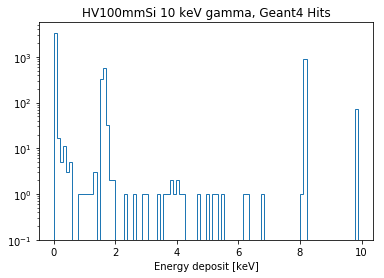

In [16]:
fig,axes = plt.subplots()
axes.hist(HV100mmData['Edep']/1e3,bins=100,histtype='step',fill=False,log=True)
axes.set_xlabel("Energy deposit [keV]")
axes.set_title("HV100mmSi 10 keV gamma, Geant4 Hits")
fig.savefig("HV100mm_sharing-Edep.png")

In [14]:
chaninfo = detectorLayout.loadGeometry(iZIP5File)

Extracting geometry data...


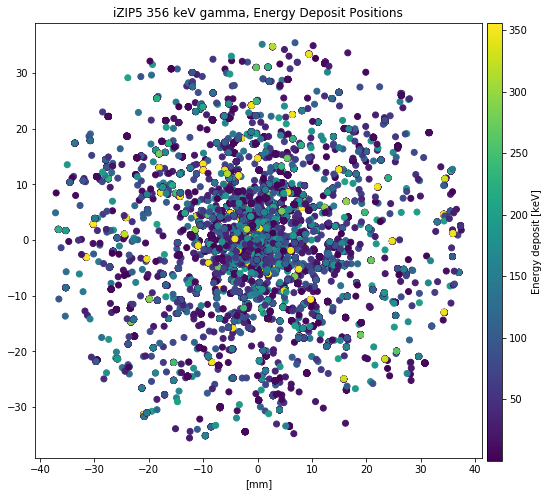

In [17]:
plt.subplots(figsize=(8,8))
plt.scatter(iZIP5data['X3']*1e3,iZIP5data['Y3']*1e3,c=iZIP5data['Edep']/1e3)
plt.title("iZIP5 356 keV gamma, Energy Deposit Positions")
plt.xlabel("[mm]")
cax = plt.axes([0.91, 0.12, 0.025, 0.76])
bar = plt.colorbar(cax=cax)
bar.set_label("Energy deposit [keV]")
plt.savefig("iZIP5_sharing-hits.png")

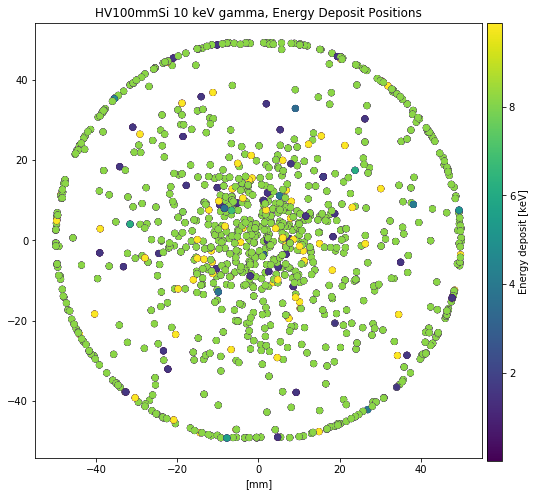

In [18]:
plt.subplots(figsize=(8,8))
plt.scatter(HV100mmData['X3']*1e3,HV100mmData['Y3']*1e3,c=HV100mmData['Edep']/1e3)
plt.title("HV100mmSi 10 keV gamma, Energy Deposit Positions")
plt.xlabel("[mm]")
cax = plt.axes([0.91, 0.12, 0.025, 0.76])
bar = plt.colorbar(cax=cax)
bar.set_label("Energy deposit [keV]")
plt.savefig("HV100mm_sharing-hits.png")

Generating detector diagram...


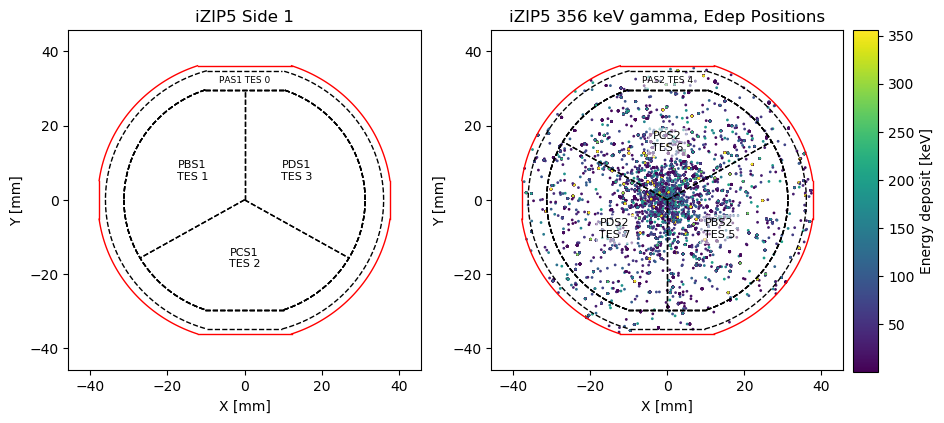

In [16]:
detectorLayout.draw(chaninfo)
plt.scatter(iZIP5data['X3']*1e3,iZIP5data['Y3']*1e3,c=iZIP5data['Edep']/1e3,s=1)
plt.title("iZIP5 356 keV gamma, Edep Positions")
cax = plt.axes([0.91, 0.12, 0.025, 0.76])
bar = plt.colorbar(cax=cax)
bar.set_label("Energy deposit [keV]")
plt.savefig("iZIP5_sharing-hits.png")